In [1]:
import pandas as pd 
import numpy as np 
df1=pd.read_csv('final-movies-dataset.csv')
df2=pd.read_csv('final-movies-dataset.csv')
# df2=pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_movies.csv')

The first dataset contains the following features:-

* movie_id - A unique identifier for each movie.
* cast - The name of lead and supporting actors.
* crew - The name of Director, Editor, Composer, Writer etc.

The second dataset has the following features:- 

* budget - The budget in which the movie was made.
* genre - The genre of the movie, Action, Comedy ,Thriller etc.
* homepage - A link to the homepage of the movie.
* id - This is infact the movie_id as in the first dataset.
* keywords - The keywords or tags related to the movie.
* original_language - The language in which the movie was made.
* original_title - The title of the movie before translation or adaptation.
* overview - A brief description of the movie.
* popularity - A numeric quantity specifying the movie popularity.
* production_companies - The production house of the movie.
* production_countries - The country in which it was produced.
* release_date - The date on which it was released.
* revenue - The worldwide revenue generated by the movie.
* runtime - The running time of the movie in minutes.
* status - "Released" or "Rumored".
* tagline - Movie's tagline.
* title - Title of the movie.
* vote_average -  average ratings the movie recieved.
* vote_count - the count of votes recieved.

Let's join the two dataset on the 'id' column


In [2]:
# df1.columns = ['id','tittle','cast','crew']
# df2= df2.merge(df1,on='id')

Just a peak at our data.

In [3]:
# df2.head(5)

# **Demographic Filtering** -
   Before getting started with this  -
* we need a metric to score or rate a movie 
* Calculate the score for every movie 
* Sort the scores and recommend the best rated movie to the users.

We can use the average ratings of the movie as the score but using this won't be fair enough since a movie with 8.9 average rating and only 3 votes cannot be considered better than the movie with 7.8 as as average rating but 40 votes.
So, I'll be using IMDB's weighted rating (wr) which is given as :-

![](https://image.ibb.co/jYWZp9/wr.png)
where,
* v is the number of votes for the movie;
* m is the minimum votes required to be listed in the chart;
* R is the average rating of the movie; And
* C is the mean vote across the whole report

We already have v(**vote_count**) and R (**vote_average**) and C can be calculated as 

Now something to keep in mind is that these demographic recommender provide a general chart of recommended movies to all the users. They are not sensitive to the interests and tastes of a particular user.
This is when we move on to a more refined system-  Content Basesd Filtering. 

# **Content Based Filtering**
In this recommender system the content of the movie (overview, cast, crew, keyword, tagline etc) is used to find its similarity with other movies. Then the movies that are most likely to be similar are recommended.

![](https://image.ibb.co/f6mDXU/conten.png)

## **Plot description based Recommender**

We will compute pairwise similarity scores for all movies based on their plot descriptions and recommend movies based on that similarity score. The plot description is given in the **overview** feature of our dataset. 
Let's take a look at the data. .. 

In [4]:
df1['description'].head(5)

0    Neerja is the story of the courageous Neerja B...
1    A story that revolves around drug abuse in the...
2    Yashvardhan Raichand lives a very wealthy life...
3    Naina an introverted perpetually depressed gir...
4    Parched' is a story about women set in the hea...
Name: description, dtype: object

For any of you who has done even a  bit of text processing before knows we need to convert the word vector of each overview.
Now we'll compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each overview.

Now if you are wondering what is term frequency , it is the relative frequency of a word in a document and is given as
   **(term instances/total instances)**.
Inverse Document Frequency is the relative count of documents containing the term is given as 
**log(number of documents/documents with term)**
The overall importance of each word to the documents in which they appear is equal to **TF * IDF**

This will give you a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document) and each row represents a movie, as before.This is done to reduce the importance of words that occur frequently in plot overviews and therefore, their significance in computing the final similarity score.

Fortunately, scikit-learn gives you a built-in TfIdfVectorizer class that produces the TF-IDF matrix in a couple of lines. That's great, isn't it? 

In [5]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df1['description'] = df1['description'].fillna('a')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df1['description'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(7653, 24065)

We see that over 20,000 different words were used to describe the 4800 movies in our dataset.

With this matrix in hand, we can now compute a similarity score. There are several candidates for this; such as the euclidean, the Pearson and the [cosine similarity scores](https://en.wikipedia.org/wiki/Cosine_similarity). There is no right answer to which score is the best. Different scores work well in different scenarios and it is often a good idea to experiment with different metrics.

We will be using the cosine similarity to calculate a numeric quantity that denotes the similarity between two movies. We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate. Mathematically, it is defined as follows:
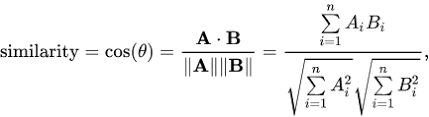

Since we have used the TF-IDF vectorizer, calculating the dot product will directly give us the cosine similarity score. Therefore, we will use sklearn's **linear_kernel()** instead of cosine_similarities() since it is faster.

In [6]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

We are going to define a function that takes in a movie title as an input and outputs a list of the 10 most similar movies. Firstly, for this, we need a reverse mapping of movie titles and DataFrame indices. In other words, we need a mechanism to identify the index of a movie in our metadata DataFrame, given its title.

In [7]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df1.index, index=df1['name']).drop_duplicates()


We are now in a good position to define our recommendation function. These are the following steps we'll follow :-
* Get the index of the movie given its title.
* Get the list of cosine similarity scores for that particular movie with all movies. Convert it into a list of tuples where the first element is its position and the second is the similarity score.
* Sort the aforementioned list of tuples based on the similarity scores; that is, the second element.
* Get the top 10 elements of this list. Ignore the first element as it refers to self (the movie most similar to a particular movie is the movie itself).
* Return the titles corresponding to the indices of the top elements.

In [8]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df1['name'].iloc[movie_indices]

In [9]:
get_recommendations('Neerja')

7316                                      Vessel
5186                                   United 93
1957                        Enakkul Oru Devathai
4638                                     Red Eye
4580                         Le peuple migrateur
3706                                  Turbulence
7411    Born to Fly: Elizabeth Streb vs. Gravity
107                                       Khakee
4737                             A Lot Like Love
4692                           Finding Neverland
Name: name, dtype: object

In [10]:
get_recommendations('The Avengers')

2857      Avengers: Age of Ultron
5994                      Plastic
301                 Kabhie Kabhie
4565                      Timecop
6976          The Last Five Years
6161        Thank You for Smoking
924                  Shubhodristi
425     Prahaar: The Final Attack
273                          Waar
5883                The Corruptor
Name: name, dtype: object

While our system has done a decent job of finding movies with similar plot descriptions, the quality of recommendations is not that great. "The Dark Knight Rises" returns all Batman movies while it is more likely that the people who liked that movie are more inclined to enjoy other Christopher Nolan movies. This is something that cannot be captured by the present system.

## **Credits, Genres and Keywords Based Recommender**
It goes without saying that the quality of our recommender would be increased with the usage of better metadata. That is exactly what we are going to do in this section. We are going to build a recommender based on the following metadata: the 3 top actors, the director, related genres and the movie plot keywords.

From the cast, crew and keywords features, we need to extract the three most important actors, the director and the keywords associated with that movie. Right now, our data is present in the form of "stringified" lists , we need to convert it into a safe and usable structure

In [11]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['description', 'language', 'genre', 'name']
# for feature in features:
#     df1[feature] = df1[feature].apply(literal_eval)

Next, we'll write functions that will help us to extract the required information from each feature.

In [12]:
# Get the director's name from the crew feature. If director is not listed, return NaN
# def get_director(x):
#     for i in x:
#         if i['job'] == 'Director':
#             return i['name']
#     return np.nan

In [13]:
# Returns the list top 3 elements or entire list; whichever is more.
# def get_list(x):
#     if isinstance(x, list):
#         names = [i['name'] for i in x]
#         #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
#         if len(names) > 3:
#             names = names[:3]
#         return names

#     #Return empty list in case of missing/malformed data
#     return []

In [14]:
# Define new director, cast, genres and keywords features that are in a suitable form.
# df2['director'] = df2['crew'].apply(get_director)

# features = ['cast', 'keywords', 'genres']
# for feature in features:
#     df2[feature] = df2[feature].apply(get_list)

In [15]:
# Print the new features of the first 3 films
# df2[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

The next step would be to convert the names and keyword instances into lowercase and strip all the spaces between them. This is done so that our vectorizer doesn't count the Johnny of "Johnny Depp" and "Johnny Galecki" as the same.

In [16]:
# Function to convert all strings to lower case and strip names of spaces
# def clean_data(x):
#     if isinstance(x, list):
#         return [str.lower(i.replace(" ", "")) for i in x]
#     else:
#         #Check if director exists. If not, return empty string
#         if isinstance(x, str):
#             return str.lower(x.replace(" ", ""))
#         else:
#             return ''

In [17]:
# Apply clean_data function to your features.
# features = ['cast', 'keywords', 'director', 'genres']

# for feature in features:
#     df2[feature] = df2[feature].apply(clean_data)

In [18]:
df1['language'].isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
7648    False
7649    False
7650    False
7651    False
7652    False
Name: language, Length: 7653, dtype: bool

In [19]:
df1['language'] = df1['language'].dropna()
df1['name'] = df1['name'].dropna()
df1['genre'] = df1['genre'].dropna()
df1['description'] = df1['description'].dropna()

In [20]:
df1['language'].isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
7648    False
7649    False
7650    False
7651    False
7652    False
Name: language, Length: 7653, dtype: bool

In [21]:
df1.head()

,movie_id,description,language,rating,writer,director,cast,genre,name,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,tt5286444,Neerja is the story of the courageous Neerja B...,Hindi,7.9,Saiwyn Quadras Sanyukta Shaikh Chawla,"[ ""Ram Madhvani"" ]",Sonam Kapoor Shabana Azmi Yogendra Tikku Abra...,"""Biography"", ""Drama"", ""Thriller""",Neerja,NaN,NaN,NaN,NaN,NaN
1,tt4434004,A story that revolves around drug abuse in the...,Hindi Panjabi,7.9,Sudip Sharma Abhishek Chaubey,"[ ""Abhishek Chaubey"" ]",Alia Bhatt Shahid Kapoor Diljit Dosanjh Karee...,"""Crime"", ""Drama"", ""Thriller""",Udta Punjab,NaN,NaN,NaN,NaN,NaN
2,tt0248126,Yashvardhan Raichand lives a very wealthy life...,Hindi Urdu,7.5,Karan Johar Sheena Parikh,"[ ""Karan Johar"" ]",Amitabh Bachchan Jaya Bhaduri Shah Rukh Khan ...,"""Drama"", ""Musical"", ""Romance""",Kabhi Khushi Kabhie Gham...,NaN,NaN,NaN,NaN,NaN
3,tt0347304,Naina an introverted perpetually depressed gir...,Hindi Urdu Gujarati Panjabi,8.0,Niranjan Iyengar Karan Johar,"[ ""Nikkhil Advani"" ]",Shah Rukh Khan Preity Zinta Saif Ali Khan Jay...,"""Comedy"", ""Drama"", ""Romance""",Kal Ho Naa Ho,NaN,NaN,NaN,NaN,NaN
4,tt3043252,Parched' is a story about women set in the hea...,Hindi,7.6,Supratik Sen Leena Yadav,"[ ""Leena Yadav"" ]",Tannishtha Chatterjee Radhika Apte Lehar Khan...,"""Drama""",Parched,NaN,NaN,NaN,NaN,NaN


In [22]:
df2.head()

,movie_id,description,language,rating,writer,director,cast,genre,name,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,tt5286444,Neerja is the story of the courageous Neerja B...,Hindi,7.9,Saiwyn Quadras Sanyukta Shaikh Chawla,"[ ""Ram Madhvani"" ]",Sonam Kapoor Shabana Azmi Yogendra Tikku Abra...,"""Biography"", ""Drama"", ""Thriller""",Neerja,NaN,NaN,NaN,NaN,NaN
1,tt4434004,A story that revolves around drug abuse in the...,Hindi Panjabi,7.9,Sudip Sharma Abhishek Chaubey,"[ ""Abhishek Chaubey"" ]",Alia Bhatt Shahid Kapoor Diljit Dosanjh Karee...,"""Crime"", ""Drama"", ""Thriller""",Udta Punjab,NaN,NaN,NaN,NaN,NaN
2,tt0248126,Yashvardhan Raichand lives a very wealthy life...,Hindi Urdu,7.5,Karan Johar Sheena Parikh,"[ ""Karan Johar"" ]",Amitabh Bachchan Jaya Bhaduri Shah Rukh Khan ...,"""Drama"", ""Musical"", ""Romance""",Kabhi Khushi Kabhie Gham...,NaN,NaN,NaN,NaN,NaN
3,tt0347304,Naina an introverted perpetually depressed gir...,Hindi Urdu Gujarati Panjabi,8.0,Niranjan Iyengar Karan Johar,"[ ""Nikkhil Advani"" ]",Shah Rukh Khan Preity Zinta Saif Ali Khan Jay...,"""Comedy"", ""Drama"", ""Romance""",Kal Ho Naa Ho,NaN,NaN,NaN,NaN,NaN
4,tt3043252,Parched' is a story about women set in the hea...,Hindi,7.6,Supratik Sen Leena Yadav,"[ ""Leena Yadav"" ]",Tannishtha Chatterjee Radhika Apte Lehar Khan...,"""Drama""",Parched,NaN,NaN,NaN,NaN,NaN


We are now in a position to create our "metadata soup", which is a string that contains all the metadata that we want to feed to our vectorizer (namely actors, director and keywords).

In [24]:
def create_soup(x):
    return ' '.join(x['description']) + ' ' + ' '.join(x['name']) + ' ' + ' '.join(x['description']) + ' ';
df1['soup'] = df1.apply(create_soup, axis=1)

The next steps are the same as what we did with our plot description based recommender. One important difference is that we use the **CountVectorizer()** instead of TF-IDF. This is because we do not want to down-weight the presence of an actor/director if he or she has acted or directed in relatively more movies. It doesn't make much intuitive sense.

In [25]:
print(df1['soup'])

0       N e e r j a   i s   t h e   s t o r y   o f   ...
1       A   s t o r y   t h a t   r e v o l v e s   a ...
2       Y a s h v a r d h a n   R a i c h a n d   l i ...
3       N a i n a   a n   i n t r o v e r t e d   p e ...
4       P a r c h e d '   i s   a   s t o r y   a b o ...
                              ...                        
7648    E l   M a r i a c h i   j u s t   w a n t s   ...
7649    A   n e w l y w e d   c o u p l e ' s   h o n ...
7650    " S i g n e d ,   S e a l e d ,   D e l i v e ...
7651    W h e n   a m b i t i o u s   N e w   Y o r k ...
7652    E v e r   s i n c e   t h e   s e c o n d   g ...
Name: soup, Length: 7653, dtype: object


In [26]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english', token_pattern=r'(?u)\b\w+\b', analyzer='word' )
count_matrix = count.fit_transform(df1['soup'])

In [27]:
print(count_matrix)

  (0, 22)	21
  (0, 14)	42
  (0, 26)	25
  (0, 18)	7
  (0, 27)	20
  (0, 28)	28
  (0, 17)	24
  (0, 23)	24
  (0, 33)	4
  (0, 15)	12
  (0, 12)	10
  (0, 29)	4
  (0, 16)	12
  (0, 11)	4
  (0, 31)	6
  (0, 13)	4
  (0, 20)	10
  (0, 24)	6
  (0, 30)	2
  (0, 3)	4
  (0, 5)	2
  (0, 9)	4
  (0, 21)	2
  (0, 7)	2
  (0, 1)	2
  :	:
  (7652, 14)	90
  (7652, 26)	75
  (7652, 18)	2
  (7652, 27)	36
  (7652, 28)	28
  (7652, 17)	33
  (7652, 23)	28
  (7652, 33)	15
  (7652, 15)	14
  (7652, 12)	8
  (7652, 29)	4
  (7652, 16)	12
  (7652, 11)	14
  (7652, 31)	16
  (7652, 13)	26
  (7652, 20)	32
  (7652, 24)	4
  (7652, 30)	2
  (7652, 21)	17
  (7652, 7)	2
  (7652, 19)	6
  (7652, 34)	4
  (7652, 0)	2
  (7652, 32)	2
  (7652, 2)	4


In [28]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [29]:
cosine_sim2

array([[1.        , 0.92279083, 0.85275064, ..., 0.91643465, 0.93113923,
        0.91797889],
       [0.92279083, 1.        , 0.85893233, ..., 0.93003162, 0.95860627,
        0.84112466],
       [0.85275064, 0.85893233, 1.        , ..., 0.80647037, 0.86909178,
        0.84427734],
       ...,
       [0.91643465, 0.93003162, 0.80647037, ..., 1.        , 0.95348452,
        0.90838093],
       [0.93113923, 0.95860627, 0.86909178, ..., 0.95348452, 1.        ,
        0.88223312],
       [0.91797889, 0.84112466, 0.84427734, ..., 0.90838093, 0.88223312,
        1.        ]])

In [30]:
# Reset index of our main DataFrame and construct reverse mapping as before
df1 = df1.reset_index()
indices = pd.Series(df1.index, index=df1['name'])

We can now reuse our **get_recommendations()** function by passing in the new **cosine_sim2** matrix as your second argument.

In [31]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

6836       The Wizard of Oz
2915        The Dark Knight
6440           The Egyptian
3746               Barnyard
4528        United Passions
3936    Aliens in the Attic
3000        Men in Black II
5946             Illuminata
7176           Serbuan maut
3276       The Hunger Games
Name: name, dtype: object

In [32]:
get_recommendations('The Godfather', cosine_sim2)

5273                          Summer Catch
6749        Beneath the Planet of the Apes
7224                 Dream with the Fishes
7436                 What Happens in Vegas
3055    Sherlock Holmes: A Game of Shadows
7104                          Mutant World
3934                       The Glimmer Man
3034                                  Home
6882                          Sleep Dealer
6246      –¢—Ä—É–¥–Ω–æ –±—ã—Ç—å –±–æ–≥–æ–º
Name: name, dtype: object

In [38]:
import pyarrow as pa
import pyarrow.parquet as pq

table = pa.Table.from_pandas(pd.DataFrame(cosine_sim2))
pq.write_table(table, 'model.parquet')